<a href="https://colab.research.google.com/github/mbasse0/Classification-Methods/blob/main/Recitation_7_Advanced_Analytics_Edge_24_25.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://drive.google.com/uc?export=view&id=10Z03hYrcPnptshIdJ5wxAoWMyOisG6Xf" width="500" />

# Binary Classification on Tabular Data - Predicting Heart Disease





## Introduction

This colab shows how to set up and train a Neural Network model for *binary classification*, when the dataset is *tabular* (rather than unstructured data like images or text) and has a mix of numeric and categorical features. Since tabular datasets are often made available in CSV files, the colab demonstrates the full CSV-to-trained-model workflow.




### The dataset

The dataset ([more background on the data](https://archive.ics.uci.edu/ml/datasets/heart+Disease)) has information on 303 patients, one in each row. Each column (i.e., feature) contains information on a particular attribute of the patient. The column named "Target" indicates if the patient has been diagnosed with heart disease or not and is the label (i.e., the dependent variable) that we want to predict using the other columns.

Feature description (copied from [here](https://keras.io/examples/structured_data/structured_data_classification_from_scratch/)):

Column| Description| Feature Type
------------|--------------------|----------------------
Age | Age in years | Numerical
Sex | (1 = male; 0 = female) | Categorical
CP | Chest pain type (0, 1, 2, 3, 4) | Categorical
Trestbpd | Resting blood pressure (in mm Hg on admission) | Numerical
Chol | Serum cholesterol in mg/dl | Numerical
FBS | fasting blood sugar in 120 mg/dl (1 = true; 0 = false) | Categorical
RestECG | Resting electrocardiogram results (0, 1, 2) | Categorical
Thalach | Maximum heart rate achieved | Numerical
Exang | Exercise induced angina (1 = yes; 0 = no) | Categorical
Oldpeak | ST depression induced by exercise relative to rest | Numerical
Slope | Slope of the peak exercise ST segment | Numerical
CA | Number of major vessels (0-3) colored by fluoroscopy | Both numerical & categorical
Thal | 3 = normal; 6 = fixed defect; 7 = reversible defect | Categorical
Target | Diagnosis of heart disease (1 = true; 0 = false) | Target

## Technical preliminaries

Throughout the course, we will load the following packages as the first step.

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

When we train Deep Learning models, randomness enters the process in a few different places.
*   Starting values for the weights (the optimizer will try to improve these weights)
*   The order in which we process the minibatches when we do SGD
*   When we split the data into Train, Validation, Test etc
*   Dropout (if we use regularization)

We next set the seed for the different random number generators so that the
results will be the same every time the notebook is run. 🤞



In [ ]:
keras.utils.set_random_seed(42)

## Read in the data

Conveniently, the dataset in CSV form has been made available online (by [Francois Chollet](https://twitter.com/fchollet)) and we can load it into a Pandas dataframe with the very useful `pd.read_csv` command.

In [ ]:
df = pd.read_csv("http://storage.googleapis.com/download.tensorflow.org/data/heart.csv")

In [ ]:
df.shape

(303, 14)

The dataset has 303 rows and 14 columns (13 independent variables + 1 dependent variable):

Let's take a look at the first few rows:

In [ ]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0,fixed,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,normal,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2,reversible,0
3,37,1,3,130,250,0,0,187,0,3.5,3,0,normal,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,normal,0


## Preprocessing

This dataset has both categorical variables and numeric variables.

We'd like to preprocess them as follows:
- *one-hot encode* the categorical variables
- *normalize* the numeric variables

It will be convenient (for later processing) to collect these groups of variables into two lists.

In [ ]:
categorical_variables = ['sex', 'cp', 'fbs', 'restecg','exang', 'ca', 'thal']
numerics = ['age', 'trestbps','chol', 'thalach', 'oldpeak', 'slope']


With the pandas `get_dummies` function, you can one-hot-encode in one line.


In [ ]:
df = pd.get_dummies(df, columns = categorical_variables)

In [ ]:
df.head()

,age,trestbps,chol,thalach,oldpeak,slope,target,sex_0,sex_1,cp_0,...,exang_1,ca_0,ca_1,ca_2,ca_3,thal_1,thal_2,thal_fixed,thal_normal,thal_reversible
0,63,145,233,150,2.3,3,0,False,True,False,...,False,True,False,False,False,False,False,True,False,False
1,67,160,286,108,1.5,2,1,False,True,False,...,True,False,False,False,True,False,False,False,True,False
2,67,120,229,129,2.6,2,0,False,True,False,...,True,False,False,True,False,False,False,False,False,True
3,37,130,250,187,3.5,3,0,False,True,False,...,False,True,False,False,False,False,False,False,True,False
4,41,130,204,172,1.4,1,0,True,False,False,...,False,True,False,False,False,False,False,False,True,False



Before we standardize the numerics, let's split the data into an 80% training set and 20% test set (*why should we split **before** normalization?*).

In [ ]:
test_df = df.sample(frac=0.2, random_state=42)
train_df = df.drop(test_df.index)

In [ ]:
train_df.shape

(242, 30)

In [ ]:
test_df.shape

(61, 30)

OK, let's calculate the mean and standard deviation of every numeric variable in the training set.

In [ ]:
means = train_df[numerics].mean()
sd = train_df[numerics].std()

In [ ]:
means

,0
age,54.268595
trestbps,131.995868
chol,246.512397
thalach,149.805785
oldpeak,1.032645
slope,1.590909


Let's standardize the train and test dataframes with these means and standard deviations.

In [ ]:
train_df[numerics]= (train_df[numerics] - means)/sd

In [ ]:
test_df[numerics]= (test_df[numerics] - means)/sd

In [ ]:
train_df.head()

,age,trestbps,chol,thalach,oldpeak,slope,target,sex_0,sex_1,cp_0,...,exang_1,ca_0,ca_1,ca_2,ca_3,thal_1,thal_2,thal_fixed,thal_normal,thal_reversible
0,0.963746,0.721939,-0.278690,0.008396,1.083461,2.226814,0,False,True,False,...,False,True,False,False,False,False,False,True,False,False
1,1.405254,1.554681,0.814423,-1.807247,0.399542,0.646494,1,False,True,False,...,True,False,False,False,True,False,False,False,True,False
2,1.405254,-0.665964,-0.361189,-0.899426,1.339930,0.646494,0,False,True,False,...,True,False,False,True,False,False,False,False,False,True
3,-1.906055,-0.110803,0.071931,1.607891,2.109339,2.226814,0,False,True,False,...,False,True,False,False,False,False,False,False,True,False
4,-1.464547,-0.110803,-0.876809,0.959447,0.314052,-0.933825,0,True,False,False,...,False,True,False,False,False,False,False,False,True,False


The easiest way to feed data to Keras/Tensorflow is as Numpy arrays so we convert our two dataframes.

In [ ]:
train = train_df.to_numpy().astype(np.float32)
test = test_df.to_numpy().astype(np.float32)

At this point, our features $X$ and dependent variable $y$ are both inside the arrays so let's separate them out.

In [ ]:
target = 6
features = list(range(train.shape[1]))
features.remove(target)

train_X = train[:, features]
train_y = train[:, target]
test_X = test[:, features]
test_y = test[:, target]

In [ ]:
train_X.shape, train_y.shape

((242, 29), (242,))

In [ ]:
test_X.shape, test_y.shape

((61, 29), (61,))

## Build a model


A Multi-Layer Perceptron (MLP) is a class of feedforward neural networks. The architecture of this neural network is composed of mulitple layers:
- an input layer
- one or multiple hidden layers
- an output layer.

It is fully connected, meaning each neuron in one layer is connected to every neuron in the subsequent layer. MLPs are used for various tasks, including classification and regression.

<img src="https://drive.google.com/uc?export=view&id=1zgbigG3W6JJazDUQTNoyZQ9dUaJ83KQ9" width="500" />

In the case of an MLP with one hidden layer, we can denote the weight matrices as follows:

- Let $W^{(1)} \in \mathbb{R}^{h \times p}$ be the weight matrix between the input layer and the hidden layer, where $p$ is the number of input features and $h$ is the number of hidden neurons.
- Let $W^{(2)} \in \mathbb{R}^{k \times h}$ be the weight matrix between the hidden layer and the output layer, where $k$ is the number of output neurons.

The input vector is denoted as $\mathbf{x} \in \mathbb{R}^d$, and the activations of the hidden layer are given by:


$\mathbf{a}^{(1)} = f(W^{(1)} \mathbf{x} + \mathbf{b}^{(1)})$

where $f$ is the activation function, and $\mathbf{b}^{(1)} \in \mathbb{R}^h$ is the bias vector for the hidden layer. The output is then computed as:

$\mathbf{y} = g(W^{(2)} \mathbf{a}^{(1)} + \mathbf{b}^{(2)})$

where $\mathbf{b}^{(2)} \in \mathbb{R}^k$ is the bias vector for the output layer and g is either:
- the identity function for regression
- the sigmoid function for binary classification (k=1)
- the softmax function for multiclass classification (k>2)

<img src="https://drive.google.com/uc?export=view&id=11CGb7Ah-y9j1mytoAoS6vMcW__AyIThG" width="300" />


### Define model in Keras

Creating an NN  is usually just a few lines of Keras code.

* We will start with a single hidden layer.
* Since this is a *binary classification problem*, we will use a sigmoid activation in the output layer.

In [ ]:
num_columns = (train_X.shape[1],)

# define the input layer
input = keras.Input(shape=num_columns)

# feed the input vector to the hidden layer
h = keras.layers.Dense(16, activation="relu", name="Hidden")(input)

# feed the output of the hidden layer to the output layer
output = keras.layers.Dense(1, activation="sigmoid", name="Output")(h)

# tell Keras that this (input,output) pair is your model
model = keras.Model(input, output)

The `model.summary()` command is a good way to get a quick overview of what you have defined.

In [ ]:
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 29)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Hidden (Dense)                       │ (None, 16)                  │             480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output (Dense)                       │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 497 (1.94 KB)

 Trainable params: 497 (1.94 KB)

 Non-trainable params: 0 (0.00 B)

We can "visualize" the network graphically as well using Keras' `plot_model` function.

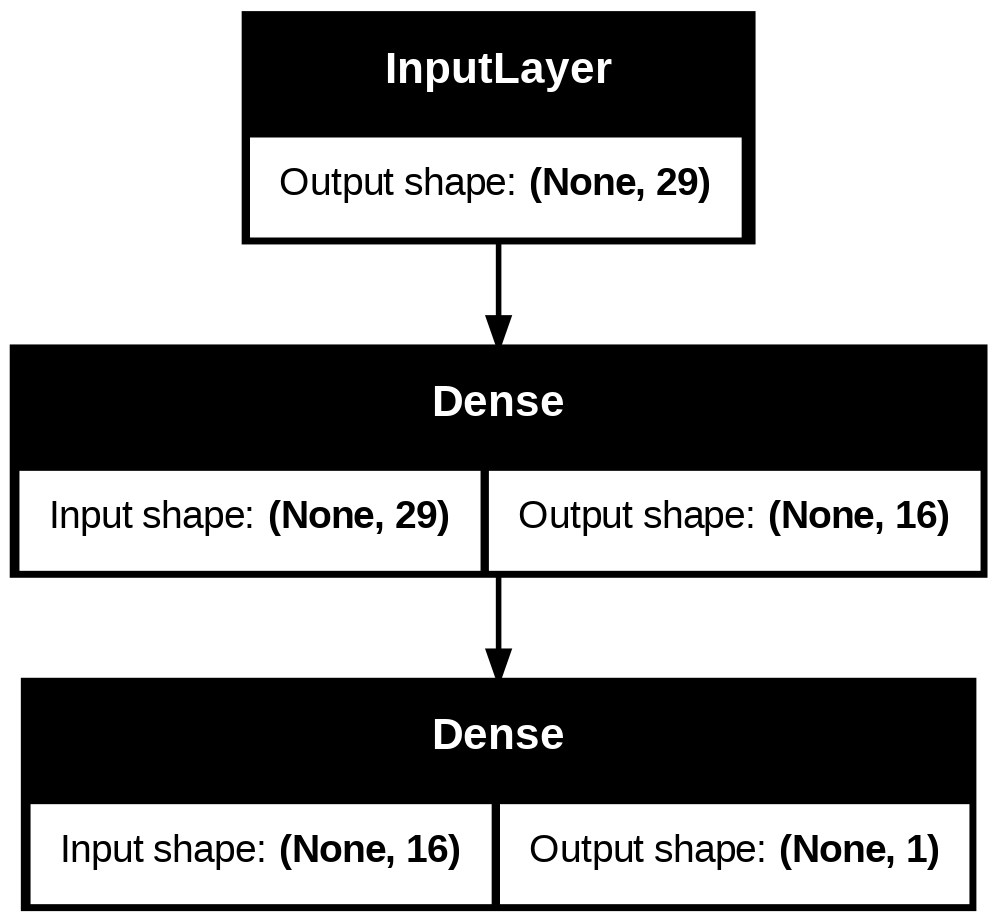

In [ ]:
keras.utils.plot_model(model, show_shapes=True)

Let's hand-calculate the number of parameters to verify.

In [ ]:
(29 + 1)* 16 + (16 + 1) * 1

497

### Set optimization parameters

Now that the model is defined, we need to tell Keras three things:

*   What **loss function** to use - Since our output variable is binary, we will select the `binary_crossentropy` loss function.
*   Which **optimizer** to use - we will use a sibling of SGD called **Adam** which is an excellent default choice
*   What **metrics** you want Keras to report out - in classification problems like this one, Accuracy is usually the metric you want to see.

In [ ]:
model.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=["accuracy"])

## Train the model

To kickoff training, we have to decide on three things:
* The *batch size* - 32 is a good default
* The number of *epochs* i.e., how many passes through the training data. Usually 20-30 epochs is a good starting point but since this dataset is very small, each epoch will be very quick so let's run it for 300 epochs. It will allow us to see if any overfitting happens
* Whether we want to use a validation set. This will be useful for overfitting detection and regularization via early stopping so we will ask Keras to automatically use 20% of the data points as a validation set

OK, let's train the model using the `model.fit` function!

In [ ]:
history = model.fit(train_X,
                      train_y,
                      epochs=300,
                      batch_size=32,
                      validation_split=0.2)

Epoch 1/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - accuracy: 0.3437 - loss: 0.7682 - val_accuracy: 0.6122 - val_loss: 0.6820
Epoch 2/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4370 - loss: 0.7252 - val_accuracy: 0.6122 - val_loss: 0.6569
Epoch 3/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5058 - loss: 0.6907 - val_accuracy: 0.6939 - val_loss: 0.6350
Epoch 4/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5954 - loss: 0.6597 - val_accuracy: 0.6939 - val_loss: 0.6157
Epoch 5/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6762 - loss: 0.6317 - val_accuracy: 0.6939 - val_loss: 0.5990
Epoch 6/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7391 - loss: 0.6060 - val_accuracy: 0.7143 - val_loss: 0.5845
Epoch 7/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7488 - loss: 0.5823 - val_accuracy: 0.7347 - val_loss: 0.5711
Epoch 8/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7692 - loss: 0.5602 - val_accuracy: 0.7143 - val_loss:

Let's plot the training and loss curves to see if ***overfitting*** is going on and if **early stopping** may be needed.

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

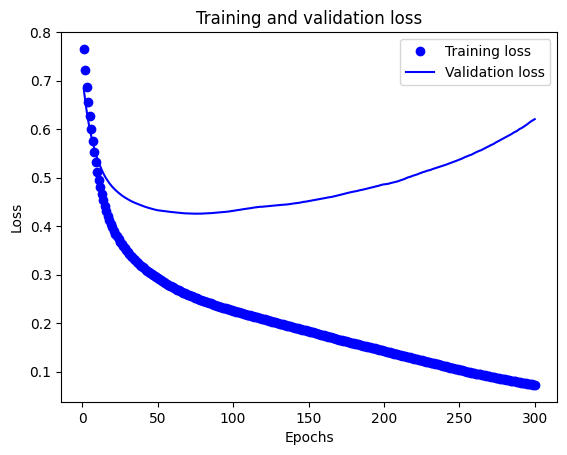

In [ ]:
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

Do you think there's overfitting?

If you think there's overfitting at epoch N, we could go back, re-initialize the model and just run it for  N epochs - that would be an example of **early stopping**.

Let's look at the accuracy curves as well.



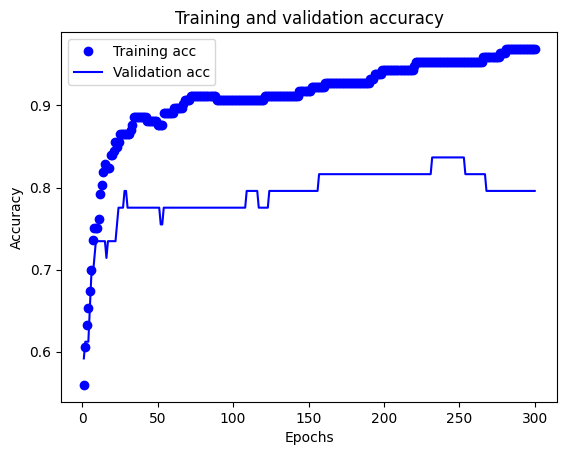

In [ ]:
plt.clf()
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

## Evaluate the model

Let's see **how well the model does on the test set**.

`model.evaluate` is a very handy function to calculate the performance of your model on any dataset.

In [ ]:
model.evaluate(test_X, test_y)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8173 - loss: 0.4115 


[0.41495442390441895, 0.8196721076965332]

## Implementing Early Stopping

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

num_columns = (train_X.shape[1],)
input = keras.Input(shape=num_columns)
h = keras.layers.Dense(16, activation="relu", name="Hidden")(input)
output = keras.layers.Dense(1, activation="sigmoid", name="Output")(h)
model = keras.Model(input, output)
model.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=["accuracy"])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(train_X,
                    train_y,
                    epochs=300,
                    batch_size=32,
                    validation_split=0.2,
                    callbacks=[early_stopping])

Epoch 1/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.7594 - loss: 0.5396 - val_accuracy: 0.6531 - val_loss: 0.6111
Epoch 2/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7664 - loss: 0.5140 - val_accuracy: 0.6531 - val_loss: 0.5988
Epoch 3/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7664 - loss: 0.4949 - val_accuracy: 0.6531 - val_loss: 0.5874
Epoch 4/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7701 - loss: 0.4779 - val_accuracy: 0.6531 - val_loss: 0.5768
Epoch 5/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7764 - loss: 0.4625 - val_accuracy: 0.6735 - val_loss: 0.5673
Epoch 6/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7655 - loss: 0.4487 - val_accuracy: 0.6735 - val_loss: 0.5586
Epoch 7/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7655 - loss: 0.4360 - val_accuracy: 0.6939 - val_loss: 0.5506
Epoch 8/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7675 - loss: 0.4244 - val_accuracy: 0.7143 - val_loss:

We are **not supposed to chose a model based on test accuracy**, but let's look at it (for educational purposes):

In [ ]:
model.evaluate(test_X, test_y)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8496 - loss: 0.3204 


[0.3291877508163452, 0.8524590134620667]